Loading CIFAR-100 dataset...


100%|██████████| 169M/169M [00:03<00:00, 49.3MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Training set loaded successfully.
Files already downloaded and verified
Test set loaded successfully.
Starting training...
Epoch [1/5], Loss: 3.5464
Epoch [2/5], Loss: 2.7718
Epoch [3/5], Loss: 2.4169
Epoch [4/5], Loss: 2.1701
Epoch [5/5], Loss: 1.9794
Training completed.
Test Accuracy: 39.97%
Confusion Matrix:
[[63  2  1 ...  0  1  0]
 [ 2 54  1 ...  0  0  1]
 [ 2  2 28 ...  1  3  0]
 ...
 [ 0  0  0 ... 39  0  1]
 [ 0  1  7 ...  1  6  2]
 [ 0  1  1 ...  0  0 32]]
Flattening images for PCA...
Computing PCA components...
PCA stopped at 87 components retaining 90% variance.


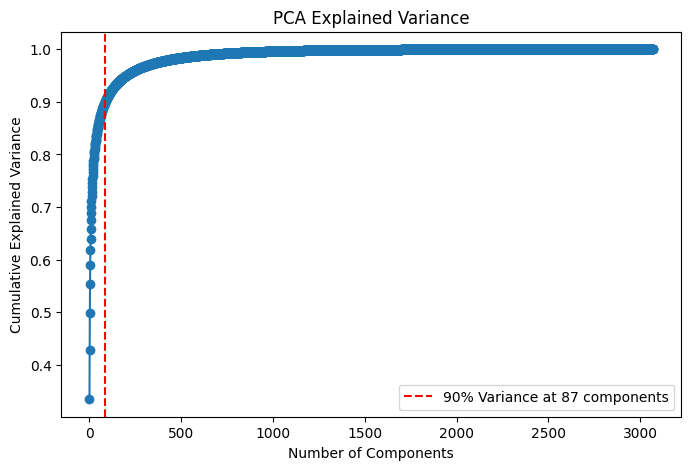

Applying K-Means Clustering...
K-Means clustering completed.


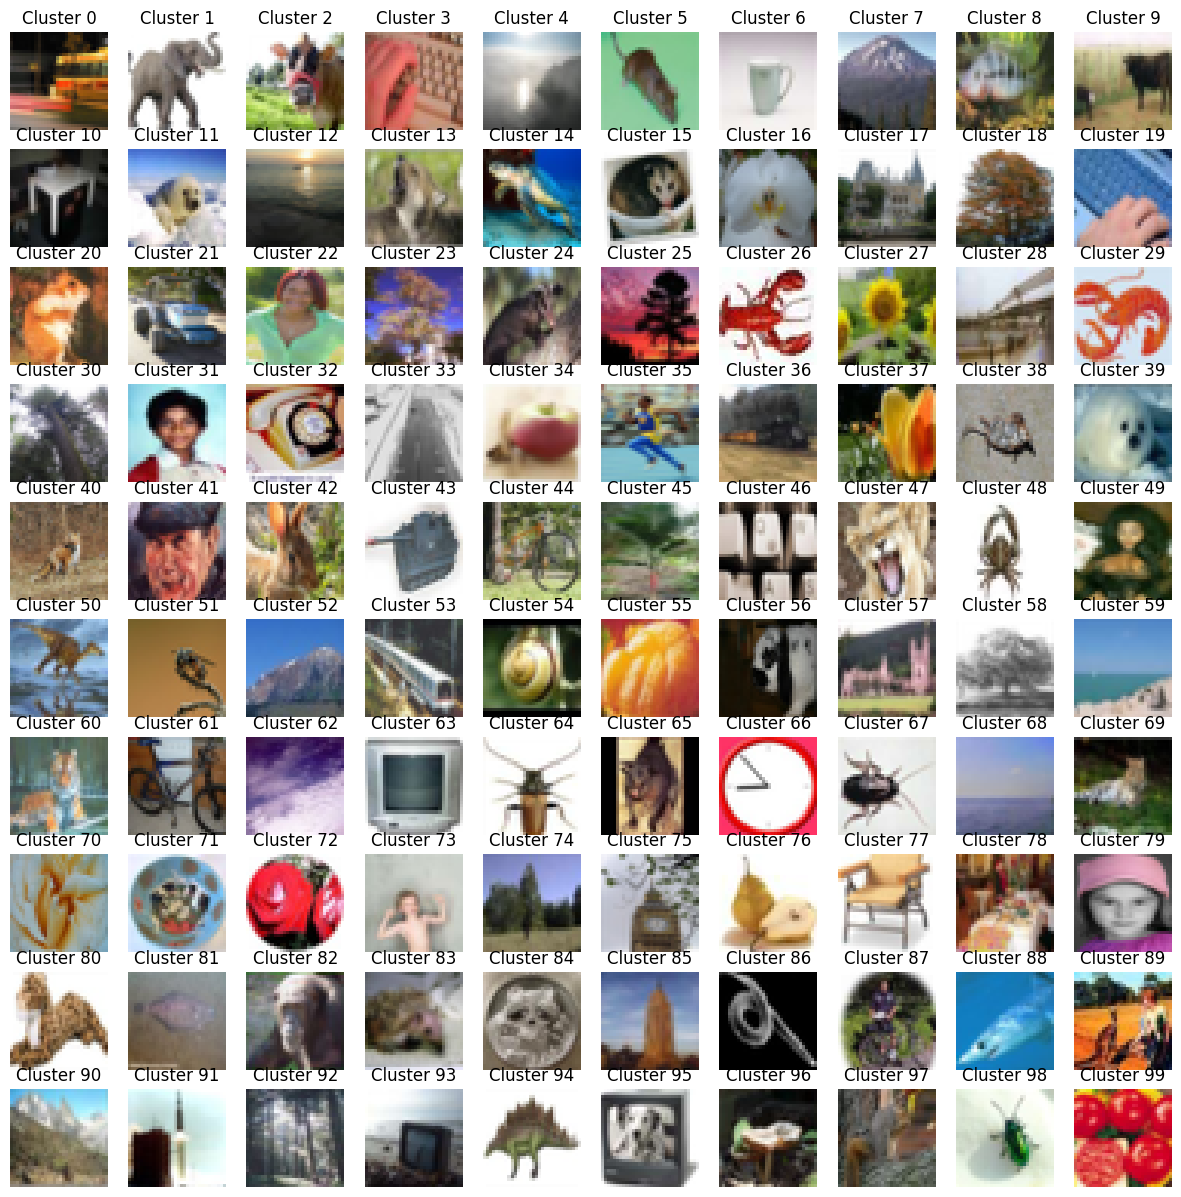

Visualization completed.


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Load CIFAR-10 Dataset
print("Loading CIFAR-100 dataset...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
print("Training set loaded successfully.")

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
print("Test set loaded successfully.")

#######################################
# Step 1: Define CNN Model
#######################################
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 100)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize CNN model
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#######################################
# Step 2: Train the CNN Model
#######################################
epochs = 5
print("Starting training...")
for epoch in range(epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}")

print("Training completed.")

#######################################
# Step 3: Evaluate the Model
#######################################
correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

#######################################
# Step 4: Apply PCA for Dimensionality Reduction
#######################################
print("Flattening images for PCA...")
X_train_flat = np.array([trainset[i][0].numpy().flatten() for i in range(len(trainset))])

print("Computing PCA components...")
pca = PCA()
X_pca_full = pca.fit_transform(X_train_flat)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.90) + 1
X_pca = X_pca_full[:, :n_components]
print(f"PCA stopped at {n_components} components retaining 90% variance.")

# Plot Cumulative Variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.axvline(n_components, color='r', linestyle='--', label=f'90% Variance at {n_components} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.title('PCA Explained Variance')
plt.show()

#######################################
# Step 5: Apply K-Means Clustering
#######################################
print("Applying K-Means Clustering...")
kmeans = KMeans(n_clusters=100, random_state=42, n_init=10)
kmeans.fit(X_pca)
clusters = kmeans.labels_
print("K-Means clustering completed.")

#######################################
# Step 6: Visualize Clustered Images
#######################################
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
cluster_samples = {c: np.where(clusters == c)[0][0] for c in range(100)}

for i, (cluster, img_idx) in enumerate(cluster_samples.items()):
    row, col = divmod(i, 10)
    axes[row, col].imshow(trainset.data[img_idx])
    axes[row, col].set_title(f"Cluster {cluster}")
    axes[row, col].axis('off')

plt.show()
print("Visualization completed.")
